# Testing with Concept Activation Vectors (TCAV) on Anthropotect Dataset and jUngle-net-rgb model

In [1]:
#.....torch imports...................
import torch
from torch.nn import Sigmoid,Tanh

#.....Captum imports..................
from captum.attr import LayerIntegratedGradients
from captum.concept import TCAV

#.....jUngleNet imports...............
import tjects


#.....helper function import..........
from utils import *

## Assembling Concepts

Here we assemble our concepts. The variable n controls, how many random datasets are used.
In order to later test, whether a concept behaves significantly different from random data, the experimental sets also contain sets that only contain random data. 
Due to hardware limitations we could not use all combinations of random concepts. 

DTD and random data should be stored in `data/tcav/images/concepts/`. Eurosat concepts should be stored in `data/eurosat/concepts/`. We used 50 eurosat images for each concept. The remaining eurosat images should also be stored somewhere if you plan to use the method of stitching multiple eurosat images together.

If you are using Eurosat concepts, the `get_tensor_from_EuroSAT_filename` function in `utils.py` has to be adjusted to use the desired filling mode to get 256 px x 256 px images. If the method of stitching multiple images together is chosen, the path from which the additional images are chosen has to be adjusted in the same function.

In [2]:
# assemble random concepts
concepts_path = "data/tcav/image/concepts/"

random_0_concept = assemble_concept("random_0", 1, concepts_path=concepts_path)

n = 9
random_concepts = [assemble_concept('random_' + str(i+1), i+2, concepts_path=concepts_path) for i in range(0, n)]

# assemble concepts to test
concepts_path = "data/eurosat/concepts/"
concept = assemble_concept("Pasture", 0, concepts_path=concepts_path)

# assemble experimental sets
experimental_sets = [[concept, random_0_concept]]
experimental_sets.extend([[concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_concepts[0]])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts[1:]])
experimental_sets.extend([[random_concepts[0], random_concept] for random_concept in random_concepts[1:]])
experimental_sets.extend([[random_concepts[1], random_concept] for random_concept in random_concepts[2:]])
# experimental_sets.extend([[random_concepts[2], random_concept] for random_concept in random_concepts[3:]])
# experimental_sets.extend([[random_concepts[3], random_concept] for random_concept in random_concepts[4:]])
# experimental_sets.extend([[random_concepts[4], random_concept] for random_concept in random_concepts[5:]])
# experimental_sets.extend([[random_concepts[5], random_concept] for random_concept in random_concepts[6:]])
# experimental_sets.extend([[random_concepts[6], random_concept] for random_concept in random_concepts[7:]])
# experimental_sets.extend([[random_concepts[7], random_concept] for random_concept in random_concepts[8:]])
# experimental_sets.extend([[random_concepts[8], random_concept] for random_concept in random_concepts[9:]])

experimental_sets

[Concept(2, 'random_1'), Concept(3, 'random_2'), Concept(4, 'random_3'), Concept(5, 'random_4'), Concept(6, 'random_5'), Concept(7, 'random_6'), Concept(8, 'random_7'), Concept(9, 'random_8'), Concept(10, 'random_9')]


[[Concept(0, 'chequered'), Concept(1, 'random_0')],
 [Concept(0, 'chequered'), Concept(2, 'random_1')],
 [Concept(0, 'chequered'), Concept(3, 'random_2')],
 [Concept(0, 'chequered'), Concept(4, 'random_3')],
 [Concept(0, 'chequered'), Concept(5, 'random_4')],
 [Concept(0, 'chequered'), Concept(6, 'random_5')],
 [Concept(0, 'chequered'), Concept(7, 'random_6')],
 [Concept(0, 'chequered'), Concept(8, 'random_7')],
 [Concept(0, 'chequered'), Concept(9, 'random_8')],
 [Concept(0, 'chequered'), Concept(10, 'random_9')],
 [Concept(1, 'random_0'), Concept(2, 'random_1')],
 [Concept(1, 'random_0'), Concept(3, 'random_2')],
 [Concept(1, 'random_0'), Concept(4, 'random_3')],
 [Concept(1, 'random_0'), Concept(5, 'random_4')],
 [Concept(1, 'random_0'), Concept(6, 'random_5')],
 [Concept(1, 'random_0'), Concept(7, 'random_6')],
 [Concept(1, 'random_0'), Concept(8, 'random_7')],
 [Concept(1, 'random_0'), Concept(9, 'random_8')],
 [Concept(1, 'random_0'), Concept(10, 'random_9')],
 [Concept(2, 'rando

## Defining jUngle-net-rgb Model

We used a pretrained RGB version of jUngleNet. This part has to be rewritten for the multispectral network or for a network trained with different channels.

In [3]:
model = tjects.experiments.asos.modules.Model(in_channels=3, n_unet_maps=3,n_classes=1, batch_norm=True, double_conv=False, dropout=None, final_activation=Sigmoid(), unet_activation=Tanh(), unet_base_channels=32, unet_mode='bilinear')
checkpoint = torch.load('./asos_anthroprotect_rgb-channels.pt',map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)
model.to('cpu')
model.eval();

# Computing TCAV Scores

Here we define the layers TCAV is to be computed on, as well as the TCAV function.

In [4]:
layers=['unet.enc1','unet.enc2','unet.enc3','unet.enc4']
# layers=['unet.dec1', 'unet.dec2', 'unet.dec3', 'unet.dec4']#, 'unet.conv_out']
# layers=['classifier.1', 'classifier.4','classifier.7','classifier.11', 'classifier.13', 'final_activation']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


d:\Programme\Anaconda\envs\tcav\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning:

Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class



We have to run TCAV for multiple sets of input data as we cannot run it with all the data at once due to hardware limitations. As the CAVs are saved after the first iteration and reused in later iterations this does not pose a problem.

In [5]:
scores = []
for i in range(0,91,10):
    input = load_image_tensors('anthropo', transform=False, start=i) # set input image class here
    input_tensors = torch.stack([transform(img) for img in input])

    score = mytcav.interpret(inputs=input_tensors, experimental_sets=experimental_sets, n_steps=5)
    scores.append(score)

d:\Programme\Anaconda\envs\tcav\lib\site-packages\captum\_utils\models\linear_model\train.py:351: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)



# Statistical significance testing of concepts

Here we test whether the classification is significantly sensitive to the chosen concepts. The results are then plotted with the bars indicating the mean TCAV score and the black line representing its standard deviation. Insignificant scores are set to 0.01. The variable n has to be set to the number of random sets used.

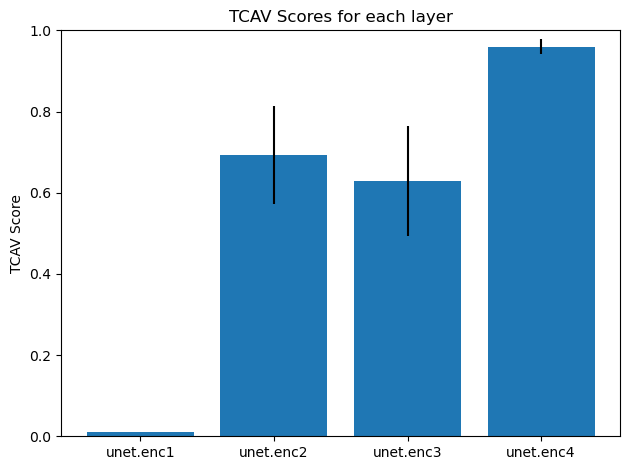

In [7]:
n = 10
plot_results(layers,experimental_sets,scores,n)